<a href="https://colab.research.google.com/github/takayama-rado/trado_samples/blob/main/colab_files/gafs_create_dataset.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 1. Download original GAFS dataset

In [1]:
from google.colab import drive

drive.mount("/content/drive")

Mounted at /content/drive


In [2]:
# Copy to local.
!cp drive/MyDrive/Datasets/gafs_dataset_orig.zip gafs_orig.zip

In [3]:
!unzip -o gafs_orig.zip

Archive:  gafs_orig.zip
   creating: inputs/
   creating: inputs/google_fs/
  inflating: inputs/google_fs/character_to_prediction_index.json  
   creating: inputs/google_fs/supplemental_landmarks/
  inflating: inputs/google_fs/supplemental_metadata.csv  
  inflating: inputs/google_fs/train.csv  
   creating: inputs/google_fs/train_landmarks/
  inflating: inputs/google_fs/train_landmarks/450474571.parquet  


In [4]:
!ls inputs/google_fs

character_to_prediction_index.json  supplemental_metadata.csv  train_landmarks
supplemental_landmarks		    train.csv


In [5]:
!cat inputs/google_fs/character_to_prediction_index.json

{" ":0,"!":1,"#":2,"$":3,"%":4,"&":5,"'":6,"(":7,")":8,"*":9,"+":10,",":11,"-":12,".":13,"\/":14,"0":15,"1":16,"2":17,"3":18,"4":19,"5":20,"6":21,"7":22,"8":23,"9":24,":":25,";":26,"=":27,"?":28,"@":29,"[":30,"_":31,"a":32,"b":33,"c":34,"d":35,"e":36,"f":37,"g":38,"h":39,"i":40,"j":41,"k":42,"l":43,"m":44,"n":45,"o":46,"p":47,"q":48,"r":49,"s":50,"t":51,"u":52,"v":53,"w":54,"x":55,"y":56,"z":57,"~":58}

In [6]:
!cat inputs/google_fs/train.csv | head

path,file_id,sequence_id,participant_id,phrase
train_landmarks/5414471.parquet,5414471,1816796431,217,3 creekhouse
train_landmarks/5414471.parquet,5414471,1816825349,107,scales/kuhaylah
train_landmarks/5414471.parquet,5414471,1816909464,1,1383 william lanier
train_landmarks/5414471.parquet,5414471,1816967051,63,988 franklin lane
train_landmarks/5414471.parquet,5414471,1817123330,89,6920 northeast 661st road
train_landmarks/5414471.parquet,5414471,1817141095,38,www.freem.ne.jp
train_landmarks/5414471.parquet,5414471,1817169529,70,https://jsi.is/hukuoka
train_landmarks/5414471.parquet,5414471,1817171518,202,239613 stolze street
train_landmarks/5414471.parquet,5414471,1817195757,136,242-197-6202


In [7]:
!ls inputs/google_fs/train_landmarks

450474571.parquet


# 2. Check data format
## 2.1 import modules

In [8]:
# Standard modules.
import os
import json
import shutil
import time

# 3rd party's modules.
import numpy as np
import h5py
import pandas as pd
import matplotlib.pyplot as plt

## 2.2 load and analyze files

### Dataset information and dictionary.

In [9]:
# Load data definition.
root_dir = "inputs/google_fs"
track_info = pd.read_csv(os.path.join(root_dir, "train.csv"))
print(track_info)

                                     path     file_id  sequence_id  \
0         train_landmarks/5414471.parquet     5414471   1816796431   
1         train_landmarks/5414471.parquet     5414471   1816825349   
2         train_landmarks/5414471.parquet     5414471   1816909464   
3         train_landmarks/5414471.parquet     5414471   1816967051   
4         train_landmarks/5414471.parquet     5414471   1817123330   
...                                   ...         ...          ...   
67203  train_landmarks/2118949241.parquet  2118949241    388192924   
67204  train_landmarks/2118949241.parquet  2118949241    388225542   
67205  train_landmarks/2118949241.parquet  2118949241    388232076   
67206  train_landmarks/2118949241.parquet  2118949241    388235284   
67207  train_landmarks/2118949241.parquet  2118949241    388332538   

       participant_id                          phrase  
0                 217                    3 creekhouse  
1                 107                 scales/ku

In [10]:
pids = track_info["participant_id"]
unique_pids = np.unique(pids)
print(unique_pids)
print(len(unique_pids))

[  0   1   2   4   6   9  10  13  15  18  20  21  24  25  27  33  36  38
  40  43  53  56  59  63  68  70  71  72  73  74  76  80  81  88  89  92
  93  95 102 105 107 109 112 113 115 117 121 122 125 128 135 136 138 141
 143 145 147 151 153 154 157 158 159 160 161 168 169 171 176 178 181 186
 187 188 192 196 202 203 216 217 219 223 225 227 230 231 233 236 239 241
 242 246 251 254]
94


In [11]:
phrases = track_info["phrase"]
unique_phrases = np.unique(phrases)
len_phrases = len(phrases)
len_unique_phrases = len(unique_phrases)
print(f"The number of total phrases:{len_phrases}")
print(f"Ther number of unique phrases:{len_unique_phrases}")
print(f"Ratio of unique phrases:{len_unique_phrases / len_phrases}")
print(f"Ratio of duplicate phrases:{(len_phrases - len_unique_phrases) / len_phrases}")

The number of total phrases:67208
Ther number of unique phrases:46478
Ratio of unique phrases:0.6915545768360909
Ratio of duplicate phrases:0.30844542316390905


### Phrase length distribution

In [12]:
lengths = np.array([len(p) for p in phrases])
max_len = np.max(lengths)
print(max_len)

31


[ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24
 25 26 27 28 29 30 31]
[    1     0     5    27    66   136   225   421   815  1295  2634 11460
  3716  3760  3977  3563  3558  3423  3184  3171  3149  3115  2579  2212
  2061  1878  1966  1540  1767  1504]


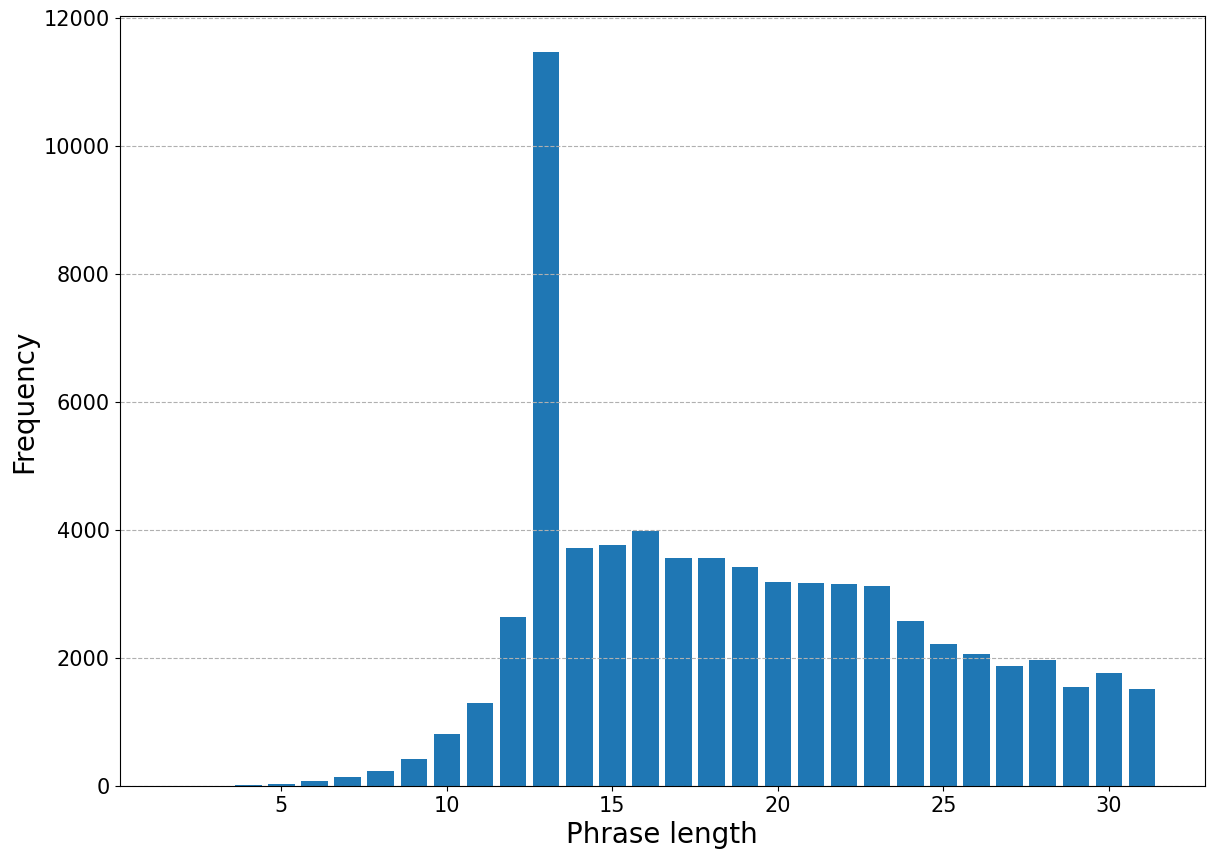

In [13]:
lengths = np.array([len(p) for p in phrases])
max_len = np.max(lengths)
histo, borders = np.histogram(lengths, bins=np.arange(1, max_len+1))

print(borders)
print(histo)

plt.figure(figsize=(14, 10))
plt.bar(borders[:-1]+1, histo, align="center")
plt.grid(axis="y", linestyle="--")
plt.xticks(fontsize=15)
plt.yticks(fontsize=15)
plt.xlabel("Phrase length", fontsize=20)
plt.ylabel("Frequency", fontsize=20)
plt.show()

### Character distribution

In [14]:
dict_file = os.path.join(root_dir, "character_to_prediction_index.json")
with open(dict_file, "r") as fread:
    key2token = json.load(fread)
characters = list(key2token.keys())
print(characters)
char_counter = {k: 0 for k in characters}

for phrase in phrases:
    for char in phrase:
        char_counter[char] += 1
print(char_counter)

[' ', '!', '#', '$', '%', '&', "'", '(', ')', '*', '+', ',', '-', '.', '/', '0', '1', '2', '3', '4', '5', '6', '7', '8', '9', ':', ';', '=', '?', '@', '[', '_', 'a', 'b', 'c', 'd', 'e', 'f', 'g', 'h', 'i', 'j', 'k', 'l', 'm', 'n', 'o', 'p', 'q', 'r', 's', 't', 'u', 'v', 'w', 'x', 'y', 'z', '~']
{' ': 58569, '!': 3, '#': 3, '$': 5, '%': 128, '&': 24, "'": 3, '(': 16, ')': 16, '*': 3, '+': 8307, ',': 40, '-': 54242, '.': 24652, '/': 19477, '0': 26744, '1': 31292, '2': 31599, '3': 29789, '4': 29810, '5': 29565, '6': 29701, '7': 28119, '8': 28202, '9': 29440, ':': 1939, ';': 1, '=': 304, '?': 302, '@': 45, '[': 2, '_': 1683, 'a': 69521, 'b': 13655, 'c': 33020, 'd': 25751, 'e': 71986, 'f': 8639, 'g': 15257, 'h': 24243, 'i': 43840, 'j': 4403, 'k': 12355, 'l': 38452, 'm': 26391, 'n': 45663, 'o': 57784, 'p': 17326, 'q': 1114, 'r': 55533, 's': 43224, 't': 47132, 'u': 20907, 'v': 10370, 'w': 28532, 'x': 2315, 'y': 11409, 'z': 3746, '~': 21}


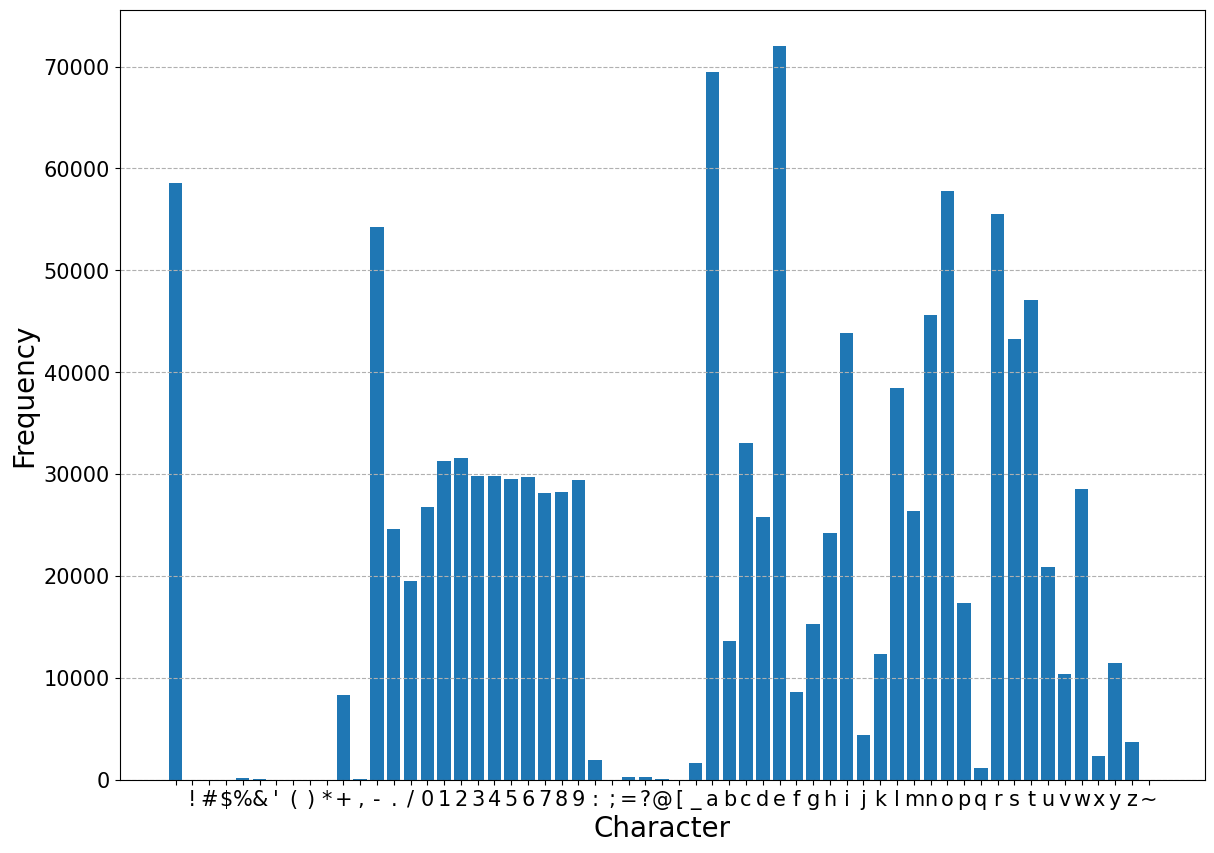

In [15]:
x = np.arange(1, len(characters)+1)
y = char_counter.values()
label_x = char_counter.keys()

plt.figure(figsize=(14, 10))
plt.bar(x, y, align="center")
plt.xticks(x, label_x)
plt.grid(axis="y", linestyle="--")
plt.xticks(fontsize=15)
plt.yticks(fontsize=15)
plt.xlabel("Character", fontsize=20)
plt.ylabel("Frequency", fontsize=20)
plt.show()

### Tracking data.

In [16]:
data_path  = os.path.join(root_dir, "train_landmarks/450474571.parquet")
data = pd.read_parquet(data_path)
print(data)

             frame  x_face_0  x_face_1  x_face_2  x_face_3  x_face_4  \
sequence_id                                                            
2138557488       0  0.663001  0.644330  0.657036  0.627135  0.640392   
2138557488       1  0.667972  0.643810  0.656717  0.626106  0.639789   
2138557488       2  0.671009  0.642717  0.655539  0.624751  0.638660   
2138557488       3  0.668623  0.641970  0.654859  0.623967  0.637923   
2138557488       4  0.669397  0.647073  0.658502  0.627655  0.643198   
...            ...       ...       ...       ...       ...       ...   
2147465106     231  0.652571  0.639059  0.644006  0.621364  0.637387   
2147465106     232  0.659162  0.641239  0.646395  0.623293  0.639435   
2147465106     233  0.663675  0.649184  0.653125  0.630293  0.647554   
2147465106     234  0.662469  0.648533  0.652406  0.630325  0.647052   
2147465106     235  0.660208  0.641396  0.646925  0.625453  0.639898   

             x_face_5  x_face_6  x_face_7  x_face_8  ...  z_rig

In [17]:
print(data.columns)
sids = data.index
unique_sids = np.unique(sids)
print(len(unique_sids))

Index(['frame', 'x_face_0', 'x_face_1', 'x_face_2', 'x_face_3', 'x_face_4',
       'x_face_5', 'x_face_6', 'x_face_7', 'x_face_8',
       ...
       'z_right_hand_11', 'z_right_hand_12', 'z_right_hand_13',
       'z_right_hand_14', 'z_right_hand_15', 'z_right_hand_16',
       'z_right_hand_17', 'z_right_hand_18', 'z_right_hand_19',
       'z_right_hand_20'],
      dtype='object', length=1630)
287


## 2.3 Main process

### Define loading function of track data.

In [18]:
# Define column names.
FACE_NUM = 468
LHAND_NUM = 21
POSE_NUM = 33
RHAND_NUM = 21
ROWS_PER_FRAME = FACE_NUM + LHAND_NUM + POSE_NUM + RHAND_NUM

FACE_COLUMNS = [[f"x_face_{i}", f"y_face_{i}", f"z_face_{i}"] for i in range(FACE_NUM)]
LHAND_COLUMNS = [[f"x_left_hand_{i}", f"y_left_hand_{i}", f"z_left_hand_{i}"] for i in range(LHAND_NUM)]
POSE_COLUMNS = [[f"x_pose_{i}", f"y_pose_{i}", f"z_pose_{i}"] for i in range(POSE_NUM)]
RHAND_COLUMNS = [[f"x_right_hand_{i}", f"y_right_hand_{i}", f"z_right_hand_{i}"] for i in range(RHAND_NUM)]
# Flatten.
FACE_COLUMNS = [item for sublist in FACE_COLUMNS for item in sublist]
LHAND_COLUMNS = [item for sublist in LHAND_COLUMNS for item in sublist]
POSE_COLUMNS = [item for sublist in POSE_COLUMNS for item in sublist]
RHAND_COLUMNS = [item for sublist in RHAND_COLUMNS for item in sublist]
# Concatenate.
COLUMNS = FACE_COLUMNS + LHAND_COLUMNS + POSE_COLUMNS + RHAND_COLUMNS

print(COLUMNS)

['x_face_0', 'y_face_0', 'z_face_0', 'x_face_1', 'y_face_1', 'z_face_1', 'x_face_2', 'y_face_2', 'z_face_2', 'x_face_3', 'y_face_3', 'z_face_3', 'x_face_4', 'y_face_4', 'z_face_4', 'x_face_5', 'y_face_5', 'z_face_5', 'x_face_6', 'y_face_6', 'z_face_6', 'x_face_7', 'y_face_7', 'z_face_7', 'x_face_8', 'y_face_8', 'z_face_8', 'x_face_9', 'y_face_9', 'z_face_9', 'x_face_10', 'y_face_10', 'z_face_10', 'x_face_11', 'y_face_11', 'z_face_11', 'x_face_12', 'y_face_12', 'z_face_12', 'x_face_13', 'y_face_13', 'z_face_13', 'x_face_14', 'y_face_14', 'z_face_14', 'x_face_15', 'y_face_15', 'z_face_15', 'x_face_16', 'y_face_16', 'z_face_16', 'x_face_17', 'y_face_17', 'z_face_17', 'x_face_18', 'y_face_18', 'z_face_18', 'x_face_19', 'y_face_19', 'z_face_19', 'x_face_20', 'y_face_20', 'z_face_20', 'x_face_21', 'y_face_21', 'z_face_21', 'x_face_22', 'y_face_22', 'z_face_22', 'x_face_23', 'y_face_23', 'z_face_23', 'x_face_24', 'y_face_24', 'z_face_24', 'x_face_25', 'y_face_25', 'z_face_25', 'x_face_26', 'y

In [19]:
def load_relevant_data_subset(pq_path):
    data = pd.read_parquet(pq_path, columns=COLUMNS)
    ids = data.index.unique()
    retval = {_id: np.array(data[data.index == _id], dtype=np.float32) for _id in ids}
    return retval

### Main loop.

In [20]:
outdir = "dataset_fs"
shutil.rmtree(outdir, ignore_errors=True)
os.makedirs(outdir, exist_ok=True)

paths = np.unique(np.array(track_info["path"]))
for path in paths:
    pq_path = os.path.join(root_dir, path)
    if not os.path.exists(pq_path):
        continue

    start = time.perf_counter()
    data = load_relevant_data_subset(pq_path)
    sids = list(data.keys())
    for sid in sids:
        meta = track_info[track_info["sequence_id"] == sid]
        pid = meta["participant_id"].values[0]
        phrase = meta["phrase"].values
        if isinstance(phrase, (tuple, list, np.ndarray)):
            phrase = phrase[0]
        tokens = np.array([key2token[p] for p in phrase])
        track = data[sid]
        # `[T, J, C]`
        track = track.reshape([track.shape[0], ROWS_PER_FRAME, -1])
        outpath = os.path.join(outdir, str(pid) + ".hdf5")
        mode = "a" if os.path.exists(outpath) else "w"
        with h5py.File(outpath, mode) as fwrite:
            # Create group and write data.
            grp = fwrite.create_group(str(sid))
            grp.create_dataset("track", data=track)
            grp.create_dataset("token", data=tokens)
    interval = time.perf_counter() - start
    print(f"Processed {path} in {interval} seconds.")

Processed train_landmarks/450474571.parquet in 3.109712645000002 seconds.


In [21]:
# Copy dictionary.
shutil.copy(dict_file, os.path.join(outdir, "character_to_prediction_index.json"))

'dataset_fs/character_to_prediction_index.json'

In [22]:
!ls -alhs dataset_fs

total 289M
4.0K drwxr-xr-x 2 root root 4.0K Sep  7 03:04 .
4.0K drwxr-xr-x 1 root root 4.0K Sep  7 03:04 ..
776K -rw-r--r-- 1 root root 775K Sep  7 03:04 0.hdf5
784K -rw-r--r-- 1 root root 781K Sep  7 03:04 102.hdf5
5.9M -rw-r--r-- 1 root root 5.9M Sep  7 03:04 105.hdf5
6.2M -rw-r--r-- 1 root root 6.2M Sep  7 03:04 107.hdf5
1.3M -rw-r--r-- 1 root root 1.3M Sep  7 03:04 109.hdf5
7.1M -rw-r--r-- 1 root root 7.1M Sep  7 03:04 10.hdf5
1.9M -rw-r--r-- 1 root root 1.9M Sep  7 03:04 112.hdf5
3.8M -rw-r--r-- 1 root root 3.8M Sep  7 03:04 113.hdf5
4.1M -rw-r--r-- 1 root root 4.1M Sep  7 03:04 115.hdf5
 44K -rw-r--r-- 1 root root  43K Sep  7 03:04 121.hdf5
3.7M -rw-r--r-- 1 root root 3.7M Sep  7 03:04 125.hdf5
3.5M -rw-r--r-- 1 root root 3.5M Sep  7 03:04 128.hdf5
7.2M -rw-r--r-- 1 root root 7.2M Sep  7 03:04 135.hdf5
3.6M -rw-r--r-- 1 root root 3.6M Sep  7 03:04 136.hdf5
9.0M -rw-r--r-- 1 root root 9.0M Sep  7 03:04 138.hdf5
 11M -rw-r--r-- 1 root root  11M Sep  7 03:04 13.hdf5
6.5M -rw-r--r-- 